# Designing enzyme inhibitors
Contents:<br>
[Exploratory data analysis](#exploratory-data-analysis)<br>
[Data processing](#data-processing)<br>
[Traditional ML baseline](#traditional-ml-baseline)<br>
[SMILES transformer model](#smiles-transformer-model)<br>
[Graph neural network model](#graph-neural-network-model)<br>
[Discussion](#discussion)<br>
***
## Overview
This notebook discusses a project on, broadly, predicting the enzyme inhibition ability of molecules using deep learning, starting from SMILES representations of the molecules. All identifying parts have redacted for privacy reasons and the code won't run as a result.

I implemented three model types for comparison: a traditional machine learning  using gradient boosting as baseline model, a transformer operating on SMILES strings, and a graph neural network operating on molecular graphs. I discuss the design, testing and evaluation of each model, and present some simple examples of deployment as a web service.

***
Notes:<br>
* Project files are in the src subfolder; specific model files are in the src/gnn and src/transformer subfolders. Mentioned files are hyperlinked.
* ML experiment tracking using mlflow was used throughout, and can be accessed by running a local mlflow server. The tracking files are stored in the "mlruns" folder.
* Model weights were also stored as mlflow artifacts; these are not included due to size constraints (available on request).
* Mlflow hyperlinks to relevant experiments are provided with the assumption the mlflow server is running locally on http://127.0.0.1:5000
* The `uv` package manager was used and the virtual environment can be installed using `uv sync` from the project root directory.
***

## Exploratory data analysis
### Data overview
We make the relevant imports and load the data. It contains:
* SMILES representations of the molecules
* Categorical features for measurement types (2) and enzyme names (4)
* Values of pKi (and pIC50, a related value) measurements as floats.

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('./DATA.csv')
df.head()

Confirm the size and shape of the provided dataset:

In [ ]:
print(f'Size of dataframe: {df.shape}')
print(f'measurement_type: {df.measurement_type.value_counts()}')
print(f'Enzyme_name: {df.Enzyme_name.value_counts()}')

### Identify data classes

While this is a regression problem, we can identify $n_{measurement-type} \times n_{Enzyme-name} = 8$ distinct subclassew within the data.

We can consider each of these classes as coming from a different underlying distribution arising from a given combination of measurement type and kinase.

We can cross-tabulate `measurement_type` against `Enzymes_name` to see how well these classes are represented.  

It looks like each class does have a distinct distribution. A good ML model should be able learn these associations if provided with appropriate conditioning to separate classes.

Consideration: if the different measurement classes were on different orders of magnitude, it would affect the gradients for backpropagation. Something like min-max scaling within classes might be useful there. Checking the range of the measurement values shows that they all lie within a small range of 6 to 12.24, so scaling is probably unneccesary.

### Explore molecule distribution

We can look at how many times each molecule is represented in the dataset.

In [ ]:
smiles_counts = df['SMILES'].value_counts()
print(f'number of unique SMILES: {len(smiles_counts)}')
print(smiles_counts)
print(smiles_counts.value_counts())

### Calculate rdkit descriptors

Let's calculate all the rdkit descriptors for the dataset - we use as these inputs for a traditional ML model to provide a comparison for deep learning models.

In [ ]:
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors.MoleculeDescriptors import MolecularDescriptorCalculator

def featurize_smiles(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        calc = MolecularDescriptorCalculator([desc[0] for desc in Descriptors.descList])
        features = dict(zip(calc.GetDescriptorNames(), calc.CalcDescriptors(mol)))
    else:
        features = {desc[0]: None for desc in Descriptors.descList}
    return features

# Apply the featurization
features_df = df['SMILES'].apply(featurize_smiles)
features_df = pd.json_normalize(features_df)

Save this file for convenience as it takes a few minutes to generate.

In [ ]:
features_df.to_csv('rdkit_features.csv', index=False)
# features_df = pd.read_csv('rdkit_features.csv') # for loading

We can use this to easily inspect many more chemical features - e.g. the molecular weight distribution of the dataset:

<Axes: >

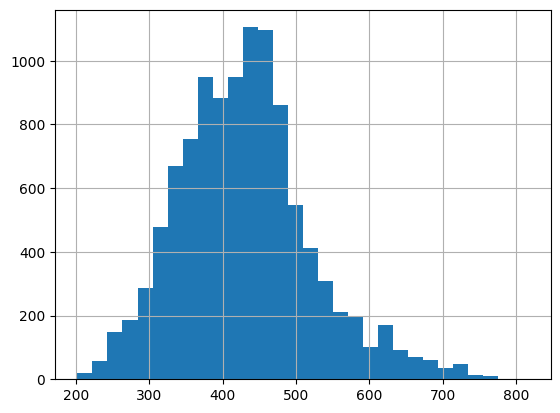

In [24]:
features_df.MolWt.hist(bins=30)

### EDA summary

* The data are imbalanced with respect to both measurement type and enzyme type. Will need to carefully design dev/test sets so that all classes are well represented.
* We have both pKi and pIC50; the problem statement is to predict pKi. We want to design a model that utilizes all data over both measurement types and all classes so that it can generalise well.
* For deep-learning models, regression outputs will need to be conditioned on measurement classes. This will also allow pIC50 measurements to be fully utilized for model training.

## Data processing

Due to the structure of the dataset, a `create_stratified_splits` function (located in [utils.py](src/utils.py)) is used instead of a standard train-development-test split function. (Note - I've used 'validation' and 'development' interchangeably in some cases)

This function addresses two issues with the dataset:
1. The target measurement is pKi, so dev and test splits with only pKi measurements were used for evaluation
2. The classes are very imbalanced, so the function specifies a fixed number of samples per class.
The dev and test sets have been set at 60 samples per class in order maintain a balance between sufficiently large splits and adequate representation of the smallest class.

For each model type presented, additional model-specific data processing is discussed in that section.

## Traditional ML baseline


[Link to train_baseline.py](src/train_baseline.py)

A scikit-learn gradient boosting (GB) regressor was used as a traditional ML baseline comparison to the deep-learning models. The GB model was chosen as a generally effective and well-known technique for tabular data. The rdkit features calculated earlier in this notebook, plus one-hot encodings of the categorical features, were used as features.

A single round of hyperparameter tuning was performed via optuna. This experiment is tracked in the mlflow experiment "[sklearn GB Architecture Search 2](http://127.0.0.1:5000/#/experiments/656276792890615830?viewStateShareKey=5573798af4a32b741e536254987277f23c1668ffa1b1182466fda950e7ce8f3b)".

The following key parameters were tuned:
* Number of estimators in the ensemble (`n_estimators`). Range: 20-200
* Maximum depth of estimators (`max_depth`). Range: 3-30
* Learning rate (`learning_rate`). Range: 0.01-0.3

Hyperparameter tuning results for the gradient boosting model are shown in the parallel coordinates plot below. The plot suggests the ranges we set for tunable parameters are good as the optimal values lie within our chosen ranges.

<p align="center">
    <img src="figures/gradient_boosting_optuna.png" alt="Gradient Boosting Optuna">
    <br>
    <em>Parallel coordinates plot showing hyperparameter search results. Each trace represents a single model and is colored by validation loss</em>
</p>

The minimum MSE obtained was ~0.32 on the dev set with parameters of max_depth = 8, n_estimators = 151, learning rate ~ 0.088. ([mlflow run](http://127.0.0.1:5000/#/experiments/656276792890615830/runs/8ac20f5615da41f0852b29fcab2784c1))

### Model evaluation
On the held-out test set, the per-class MSEs show that the model has much better performance on ENZ1 compared to the other classes ([mlflow run](http://127.0.0.1:5000/#/experiments/824897664922855667/runs/013a4bf8361942cc8a160dc2f3087561)). Worse performance on the underrepresented classes is expected, however overperformance on ENZ1 vs ENZ2 should be investigated further as these classes had a similar number of data samples.

Kinase_name | pKi MSE
--- | ---
ENZ1 | 0.096965
ENZ2 | 0.262585
ENZ3 | 0.366490
ENZ4 | 0.334674
Overall | 0.265178


### Example deployment
[app_baseline.py](src/app_baseline.py)

I demonstrate an interaction with simple test deployment of the model running as a web service on a local server below. The service is written in flask and runs a model pulled from the local mlflow server. The user sends the details of a molecule and the measurement conditions (SMILES string, measurement type (pKi or pIC50), and Kinase name (ENZ1, ENZ2, ENZ3, ENZ4)).

The service featurizes the molecule, encodes the measurement conditions, runs the predictive model and returns a predicted value. (In this case, the real value is 7.36)

In [ ]:
import requests

# Define the URL of the Flask app
url = 'http://localhost:5001/predict'

# Define the input data
data = [
    {
        "SMILES": "C#CCNCC1CCC(c2nnn3cnc4[nH]ccc4c23)CC1",
        "measurement_type": "pIC50",
        "enzyme_name": "ENZ2"
    }
]

# Send a POST request to the /predict endpoint
response = requests.post(url, json=data)

# Print the response from the server
if response.status_code == 200:
    print("Predictions:", response.json())
else:
    print("Error:", response.json())

Predictions: [7.456266114089111]


Random chemical drawn from test set

| SMILES | measurement_type | measurement_value | enzyme_name |
|--------|------------------|-------------------|------------|
| CN1CCN(C(=O)Cn2cc(NC(=O)c3cnn4cccnc34)c(-c3cc(Cl)ccc3OC(F)F)n2)C(C)(C)C1 | pKi | 9.25 | ENZ1 |
| CN1CCN(C(=O)Cn2cc(NC(=O)c3cnn4cccnc34)c(-c3cc(Cl)ccc3OC(F)F)n2)C(C)(C)C1 | pKi | 8.89 | ENZ2 |

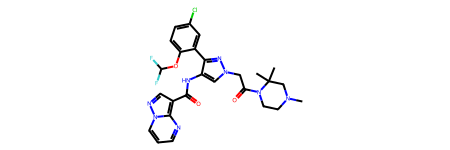

In [25]:
from rdkit import Chem

Chem.MolFromSmiles("CN1CCN(C(=O)Cn2cc(NC(=O)c3cnn4cccnc34)c(-c3cc(Cl)ccc3OC(F)F)n2)C(C)(C)C1")

## SMILES transformer model

### Model development
I chose to develop a transformer-based model based on several desirable features:
* SMILES is a widely used and convenient sequence-based representation for molecules.
* Transformers are an established, scalable architecture for sequence-based models.
* The molecules in the dataset are small enough such that a transformer attention mechanism should be possible to capture the multi-atom relationships that are responsible for biological actvity.
* Extensive existing transformer-related codebases such as Hugging Face's `transformers` could be leveraged if necessary.

This model was developed in pytorch without additional frameworks. Pytorch already has good support for transformers, and a pure pytorch implementation allowed for greater control over the architecture.

#### Initial search
The first [model architecture](src/transformer/model.py) tested used sinusoidal positional encoding and a transformer encoder architecture with a final linear layer for regression. A key consideration was how to introduce class conditioning information. Based on the ability of transformers to propagate information via self-attention, I chose to prepend special tokens representing measurement type and kinase type to the transformer input. This choice also allows classes to be specified during inference in the same manner for prediction across kinases.

The MSE loss values are not directly comparable to later runs but are internally comparable (target values from different measurement types were normalized by measurement type in an effort to avoid different scales biasing training gradients, but this was later decided to be the wrong strategy as this destroys discriminative information). 

An initial model hyperparameter search was run over 50 iterations optimizing key parameters in the ranges below: 
* embedding size (`hidden_dim`): [256, 512, 768]
* number of attention heads (`num_heads`): [4, 8, 16]
* number of layers (`num_layers`): [6 - 12, integer]
* dropout probability (`dropout`): [0.1 - 0.5, float]

(mlflow experiment "[Transformer Architecture Search](http://127.0.0.1:5000/#/experiments/429830334311556039?viewStateShareKey=60b5838b3c07b10d688fd52b4dd6c37593b139dcfb12d21877e12fcb552682f6)")

<p align="center">
    <img src="figures/transformer_optuna_parallel.png" alt="Transformer Optuna Parallel">
    <br>
    <em>Parallel coordinates plot from hyperparameter search linking transformer parameters to validation loss.</em>
</p>

This plot indicates that embedding size and number of attention heads above a certain level are crucial. Both of these parameters are linked to model capacity, indicating that the expressiveness of tokens and links between them may not be saturated with this model architecture. Number of transformer layers was less important, indicating sufficient propagation of infomation.

<p align="center">
    <img src="figures/transformer_optuna_loss.png" alt="Transformer Optuna Loss">
    <br>
    <em>Overlaid training loss curves from hyperparameter search. y-axis: MSE loss in log scale. x-axis: training epochs.</em>
</p>

The overlaid training curves show that under certain conditions, training does not converge or undergoes a long initial plateau period - direct inspection of these runs shows these arise primarily from high dropout rates above 0.2, as would be expected for excessive regularization.

#### Updating architectural choices
After updating the system to use unscaled target values, model performance was reappraised against the gradient boosting baseline model and found to be worse. The positional encoding architecture was considered as a point of potential improvement: the sinusoidal encoding chosen initially only encodes absolute positions. SMILES strings are degenerate to a given molecule, so relative positions might aid generalization. A relative positional encoder, RoPE, was then tested using the `torchtune` library implementation, [`RotaryPositionalEmbeddings`](https://pytorch.org/torchtune/0.3/generated/torchtune.modules.RotaryPositionalEmbeddings.html#torchtune.modules.RotaryPositionalEmbeddings). The initial test with this encoder showed training loss lower than any previous run, however validation loss did not improve significantly. This indicated the RoPE encoder was improving the model's ability to learn the training set, but this was not generalizing ([mlflow run](http://127.0.0.1:5000/#/experiments/431121963238412000/runs/ef6bf6825f5a4112bd93b05e2e2c7acb)).

To provide regularization the model capacity was reduced, dropout increased, weight decay, and learning rate warmup/decay were implemented ([mlflow run](http://127.0.0.1:5000/#/experiments/431121963238412000/runs/372d334383784b0093884a09192964b7)). However, the learning curves showed the same overfitting pattern.

<p align="center">
    <img src="figures/RoPE_regularization.png" alt="RoPE Regularization">
    <br>
    <em>Training and validation loss curves for the first RoPE model (green: training, red: validation) and for the model with regularizations (blue: training, orange: validation). y-axis: MSE loss in log scale. x-axis: training epochs.</em>
</p>

An additional form of regularization was introduced via SMILES string scrambling (as SMILES strings have multiple equivalent representations for a given molecule), which can also be considered a form of data augmentation. The aim of this was to prevent the model's ability to memorize specific SMILES strings, in order to improve generalization. The initial test reduced training set overfitting but did not change validation set results ([mlflow run](http://127.0.0.1:5000/#/experiments/431121963238412000/runs/d454fdfbd9bc4f30964d23c70986a30a)). Other forms of regularization were then reduced and model capacity increased again ([mlflow run](http://127.0.0.1:5000/#/experiments/431121963238412000/runs/40dd666bf60640ba950bb01f11f6e20c)); a comparison between the learning curves for this and the first RoPE model are shown below. 

<p align="center">
    <img src="figures/RoPE_SMILES_scrambling.png" alt="RoPE SMILES Scrambling">
    <br>
    <em>Training and validation loss curves for first RoPE model (green: training, red: validation) and for the high capacity scrambled SMILES model (blue: training, orange: validation). y-axis: MSE loss in log scale. x-axis: training epochs.</em>
</p>

Having made these changes, we see a reduction in training-set overfitting but no significant improvement in generalization ability on the validation set.

Note: A mistake was made where the SMILES strings of the validation set were also dynamically scrambled. A run fixing this was performed ([mlflow run](http://127.0.0.1:5000/#/experiments/431121963238412000/runs/5ace52da25254652a3a9c358f84300fb)) but no major differences in validation loss were observed.

#### Summary
A SMILES transformer for class-based regression was developed. Several augmentations were tested: hyperparameter tuning in the transformer architecture, positional encoder variations, and SMILES string scrambling for regularization/data augmentation. Technical details are described in the sections below.

### Dataset setup
[dataset.py](src/transformer/dataset.py)

A torch `Dataset`, `SMILESDataset` is defined which ingests the provided data as a dataframe.

The `__getitem__` returns the tokenized SMILES strings prepended with two special tokens representing measurement type and kinase name.

The token vocabulary is pre-calculated from the dataframe and a list of special tokens using the `build_vocabulary` function in [utils.py](src/utils.py) and then passed as an initialization argument to `SMILESDataset`. For a production deployment, a vocab should be pre-calculated which works for all possible SMILES strings.

The `create_stratified_splits` function is used to ensure class representation.

Additional helper functions `collate_fn` and `create_loaders` are used to pad batches and create dataloaders, respectively.

### Model setup
The model `TransformerModel` is based on transformer encoder architecture with a linear layer over the output logits to perform regression. Dropout layers are used to provide regularization.

In [model.py](src/transformer/model.py), sinusoidal positional encoding is implemented via `PositionalEncoding`.

In [model_rope.py](src/transformer/model_rope.py) a relative positional encoding `RotaryPositionalEmbeddings` is used from the `torchtune` library.

The embedding size (`hidden_dim`), number of attention heads (`num_heads`), number of layers (`num_layers`), and dropout probability (`dropout`) are written as variables so that they can be optimized via hyperparameter search.

### Training setup
[train_transformer.py](src/train_transformer.py)

The function `train_one_epoch` defines a single training epoch. `validate` defines a validation epoch. An optional data scaling capability is implemented (and tested with min-max scaling) but was not used in later experiments.

In a single training run:<br>
* Tracking is set up using a local mlflow server.
* Dataloaders are set up (see "Dataset Setup" for further details)
* Transformer model parameters are specified
* A loss criterion is defined. Mean squared error was chosen as a standard loss for regression problems.
* An optimizer and learning rate are defined. The Adam optimizer with learning rate 1e-4 was chosen as a generally effective option.
* Regularizations are selected: weight decay, learning rate scheduling, annealing strategy
* A training loop is run by calling `train_one_epoch` and `validate` for a fixed number of epochs. Loss metrics are logged to mlflow for visualization and analysis.

### Hyperparameter optimization
[hyperparameter_search_transformer.py](src/hyperparameter_search_transformer.py)

Bayesian hyperparameter optimization was performed using the optuna framework.

Key neural architecture parameters were optimized:
* embedding size (`hidden_dim`)
* number of attention heads (`num_heads`)
* number of layers (`num_layers`)
* dropout probability (`dropout`)

Trials were also logged with mlflow to provide tracking.

### Model evaluation
Like the gradient boosting model, the transformer model has much better performance on ENZ1 compared to the other classes ([mlflow run](http://127.0.0.1:5000/#/experiments/181390553139269171/runs/193d252eb46e4ff69c1b614750ffdfc4)).

enzyme_name | pKi MSE
--- | ---
ENZ1 | 0.122952
ENZ2 | 0.450943
ENZ3 | 0.591636
ENZ4 | 0.811755
Overall | 0.494321

### Deployment
[app_transformer.py](src/app_transformer.py)

A web service with a similar API to the one implemented for the gradient boosting model is demonstrated below. A different backend is used to preprocessthe input. The service is written in flask and runs a pytorch model pulled from the local mlflow server. The user sends the details of a molecule and the measurement conditions (SMILES string, measurement type (pKi or pIC50), and enzyme name.

The service tokenizes the molecule and measurement conditions, runs the SMILES transformer model and returns a predicted value. (Again, the real value is 7.36)

In [ ]:
import requests

# Define the URL of the Flask app
url = 'http://localhost:5001/predict'

# Define the input data
data = {
        "SMILES": "C#CCNCC1CCC(c2nnn3cnc4[nH]ccc4c23)CC1",
        "measurement_type": "pIC50",
        "enzyme_name": "ENZ2"
    }

# Send a POST request to the /predict endpoint
response = requests.post(url, json=data)

# Print the response from the server
if response.status_code == 200:
    print("Predictions:", response.json())
else:
    print("Error:", response.json())

Predictions: [[7.841602325439453]]


## Graph neural network model

Compared to a string based model, a graph-based model has several advantages:
* A graph is a natural representation for molecules
* Using a graph representation removes the problem of degenerate SMILES strings as the final graph embedding is SMILES-permutation invariant
* Additional chemical information can, in principle, be encoded in both graph nodes and edges.
* While less common than transformers, there are plenty of existing codebases designed for deep learning on graphs.

I chose to develop this model in pytorch using the pytorch-geometric framework for computations on graphs.

### Model development
The core architecture of stacked graph convolutional layers for learning molecules is very well established (in e.g. [Kipf & Welling 2017](https://arxiv.org/abs/1609.02907)). My main concern was how to introduce class conditioning information (measurement type and kinase name). An initial attempt was to append this information as a one-hot vector to each atom node's feature vector, but this did not work well and seemed inelegant. I then decided on the approach of embedding the class information into the graph model's hidden dimension and adding it after pooling: [model.py](src/gnn/model.py).

<p align="center">
    <img src="figures/gnn_training_dynamics.png" alt="GNN Training Dynamics">
    <br>
    <em> Exploratory training curves for the graph model with a range of hyperparameters. y-axis: MSE loss in log scale. x-axis: training epochs.</em>
</p>

The figure above shows the inital testing of model hyperparameters and how they affect the model training loss. The first experiment, represented by the brown trace (hidden dimension = 32, layers = 3) showed extremely slow convergence, so model hidden dimension was increased to 128. The other trials in this plot show different combinations of larger hidden dimension and more layers. All showed similar training dynamics - an initial rapid convergence period, followed by a loss plateau.

To further optimize this model, several parameters were considered for hyperparameter search:
* embedding size (`hidden_dim`): [256, 512, 768]
* number of layers (`num_layers`): [3 - 10, integer]
* convolutional layer type (`conv_type`): [GATConv, GCNConv, SAGEConv, GraphConv, TAGConv]
* normalization layer type (`norm_type`): [None, LayerNorm, BatchNorm]
* pooling layer type (`pool_type`): [global_mean_pool, global_max_pool, global_add_pool]

A selection of convolutional layer types with different designs were tested: GATConv, GCNConv, SAGEConv, GraphConv, TAGConv. These were chosen from pytorch geometric's library of convolution layers, based on differences in terms of how they aggregate information - e.g. GATConv uses graph attention, while TAGConv learns graph topology. Normalization layers were tested to see if they improved training dynamics. Three common pooling layers were tested to see if they improved the model's ability to generalize by providing different ways of aggregating node information. The hyperparameter search results are tracked in this [mlflow experiment](http://127.0.0.1:5000/#/experiments/429055189571193624?viewStateShareKey=381a0e300ab95848b02f3396ae0b80929e2073078e09976563757138a9db2a9b).

<p align="center">
    <img src="figures/gnn_parallel.png" alt="GNN Hyperparameter Search">
    <br>
    <em>Parallel coordinates plot from hyperparameter search linking GNN parameters to validation loss. The labels to categorical features could not be rendered correctly but are described below.</em>
</p>

The following parameters were found to perform well:
* embedding size: 768 (as this was the largest option, higher dimensionalities may work even better)
* number of layers: 5 (4-6 seemed to work best)
* convolutional layer type: TAGConv (topology adaptive graph convolution)
* normalization layer type: BatchNorm
* pooling layer type: global_mean_pool (global_add_pool performed significantly worse)

In terms of validation loss, the best GNN models performed similarly to the best transformer models.

Technical details are described in the sections below.

### Dataset setup
[dataset.py](src/gnn/dataset.py)

A torch `Dataset`, `GraphDataset` is defined which ingests the provided data as a dataframe.

The `__getitem__` uses rdkit to convert the SMILES string into a rdkit mol. Atomic features are added to the nodes (atoms) via a one-hot encoding of element type. The method returns a pytorch geometric data item along containing node and edge information. A one-hot encoding of categorical features is added as the `cat_features` attribute to be used for conditioning.

A `create_loaders` helper function is defined that uses pytorch geometric's GeometricDataLoader designed for graph data.

### Model setup
[model.py](src/gnn/model.py)

The model `GraphModel` is based on a graph convolutional architecture with a linear layer over the output logits to perform regression. In order to condition the model on measurement type and kinase name, the one-hot categorical feature vector calculated in the `GraphDataset` is embedded into the model hidden dimension through a linear layer and added to the pooled graph embedding.

The embedding size (`hidden_dim`), convolutional layer type (`conv_type`), number of layers (`num_layers`), presence and type of normalization layers (`norm_type`) and dropout probability (`dropout`) are left as variables which can be optimized via hyperparameter search.

### Training setup
[train_gnn.py](src/train_gnn.py)

The GNN training script is very similar to the transformer script, except for data preprocessing and model setup. 

The function `train_one_epoch` defines a single training epoch. `validate` defines a validation epoch.

In a single training run:<br>
* Tracking is set up using a local mlflow server.
* Dataloaders are set up (see "Dataset Setup" for further details)
* Graph model parameters are specified
* A loss criterion is defined.
* An optimizer and learning rate are defined.
* A training loop is run by calling `train_one_epoch` and `validate` for a fixed number of epochs. Loss metrics are logged to mlflow for visualization and analysis.

### Hyperparameter optimization
[hyperparameter_search_gnn.py](src/hyperparameter_search_gnn.py)

Bayesian hyperparameter optimization was performed using the optuna framework.

Key neural architecture parameters were optimized:
* embedding size (`hidden_dim`): [256, 512, 768]
* number of layers (`num_layers`): [3 - 10, integer]
* convolutional layer type (`conv_type`): [GATConv, GCNConv, SAGEConv, GraphConv, TAGConv]
* normalization layer type (`norm_type`): [None, LayerNorm, BatchNorm]
* pooling layer type (`pool_type`): [global_mean_pool, global_max_pool, global_add_pool]

Trials were also logged with mlflow to provide tracking.

### Model evaluation
Compared to the transformer model, the GNN model improved on ENZ4 while being worse on ENZ1, leading to a similar overall test loss ([mlflow run](http://127.0.0.1:5000/#/experiments/559023913998728002/runs/c1898b63ffad4ac69d23e10e86346570)). Further research may show if the two models differ in their capacity to represent specific chemical concepts.

Kinase_name | pKi MSE
--- | ---
ENZ1 | 0.229687
ENZ2 | 0.635797
ENZ3 | 0.521044
ENZ4 | 0.587860
Overall | 0.493597

## Final discussion
A comparison of model evaluation metrics on the held-out test set of 60 pKi samples from each kinase class is shown in the table below. Further work such as a statistical comparison of cross-validation scores would clarify the significance of comparing scores between classes but we can see that all models gave MSE test losses of below 0.5, corresponding to a pKi difference of less than 1. 


This would be sufficient to identify lead molecules with high selectivity for further investigation.

Kinase_name |  Gradient Boosting (pKi MSE) | Transformer (pKi MSE) | GNN (pKi MSE)
--- | --- | --- | ---
ENZ1 | 0.096965 | 0.122952 | 0.229687
ENZ2 | 0.262585 | 0.450943 | 0.635797
ENZ3 | 0.366490 | 0.591636 | 0.521044
ENZ4 | 0.334674 | 0.811755 | 0.587860
Overall | 0.265178 | 0.494321 | 0.493597

The gradient boosting regressor seemingly outperforms both the deep learning models. The handcrafted molecular featurization routines found in rdkit and other packages may provide additional domain knowledge beyond the pure SMILES string. Both deep learning models reached a similar level of performance slightly below that of the gradient boosting model, suggesting they may be nearing the maximum predictive ability of a pure SMILES representation.

This suggests that adding handcrafted features to a deep learning model might improve performance, particularly for small datasets. For example, a feature-importance ranking method such SHAP could be used on the gradient boosting model to select the most useful features. To implement a hybrid deep learning model, features could be introduced as special tokens in the transformer model, or by concatenation to the categorical features in the GNN model. Another clear possibility for GNN model improvement is to add more node and edge features to the molecular graph—e.g. atomic properties such as electronegativity, or bond features such as bond order.

An alternative direction that would likely have clear performance benefits is pre-training the deep learning models on a large chemical corpus before finetuning on tasks like this kinase challenge. The pre-trained models could also be repurposed for other applications. Alternatively, existing pre-trained models could be used as base models.

Interpretability would also be an interesting research direction, possibly leading to deeper chemical understanding of the inhibition mechanisms. As mentioned above, simple feature importance rankings can be useful for traditional ML models. For the transformer model, visualization of attention head activation may provide clues as to which chemical components are linked to kinase inhibition activity. For the GNN, an analogous study could be done visualizing the graph convolutions. This could lead to the identification of new pharmacophores.

Example deployments were shown of two of the models as web services. In production, these deployments would need to be built out in several ways. The services would need to be containerized and run on cloud servers. Models could be continually be trained with new data using automated pipelines and orchestrated by a mlflow server or other similar service. Many aspects of the API would need to be made more robust and secure. Two potential uses of such a service would be for direct consumption by research chemists, and for usage in automated computational pipelines.